In [1]:
data = {
    'proj_file': '/home/ravescovi/Downloads/NSLS2/scan_00244/proj_00000.hdf',
    'angles_file': '/home/ravescovi/Downloads/NSLS2/scan_00244/scan_00244.nxs',
    'dark_file': '/home/ravescovi/Downloads/NSLS2/scan_00245/dark_00000.hdf',
    'flat_file': '/home/ravescovi/Downloads/NSLS2/scan_00245/flat_00000.hdf',
    'recon_init': 1000,
    'recon_end': 1512,
    'rot_center': None,
}

In [2]:
import sys
sys.path.append('/home/ravescovi/workspace/tomography_flow')
import matplotlib.pyplot as plt
from tomo_flow.recon import load_data, recon_data, save_data, save_images

proj_file = data['proj_file']
proj_file = data['proj_file']
flat_file = data['flat_file']
dark_file = data['dark_file']
angles_file = data['angles_file']
recon_init = data['recon_init']
recon_end = data['recon_end']
rot_center = data['rot_center']

proj, flats, darks, theta = load_data(proj_file, flat_file, dark_file, angles_file, recon_init, recon_end)
recon, proj_norm, rot_center = recon_data(proj, flats, darks, theta)
save_data(recon, rot_center, '/home/ravescovi/Downloads/NSLS2/scan_00244/recon_')
save_images(proj_norm, recon, '/home/ravescovi/Downloads/NSLS2/scan_00244/recon_')


proj (1801, 512, 3200) uint16
flats (50, 512, 3200) uint16
darks (20, 512, 3200) uint16
theta (1801,) float32
proj_norm (1801, 512, 3200) float32
rot_center 1609.25
proj_norm_ml (1801, 512, 3200) float32
recon (512, 3200, 3200)


astropy module not found
olefile module not found


Reconstruction data saved with shape: (512, 3200, 3200)
Rotation center saved: /home/ravescovi/Downloads/NSLS2/scan_00244/recon_/center.txt
Projection image saved as /home/ravescovi/Downloads/NSLS2/scan_00244/recon_/proj.png
Reconstruction image saved as /home/ravescovi/Downloads/NSLS2/scan_00244/recon_/recon.png


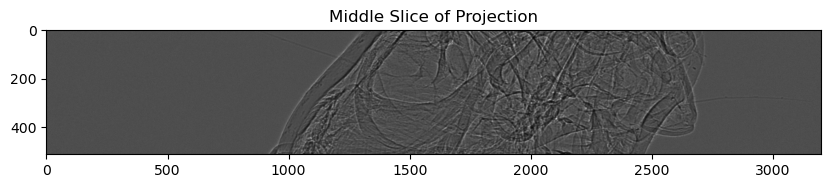

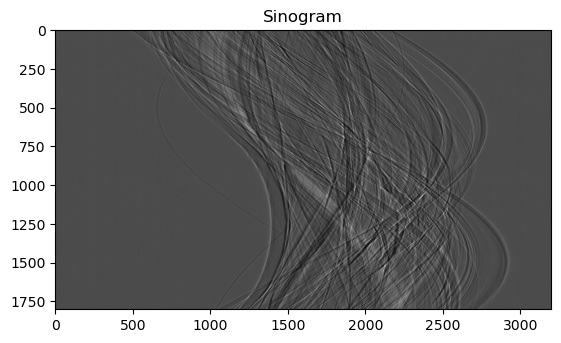

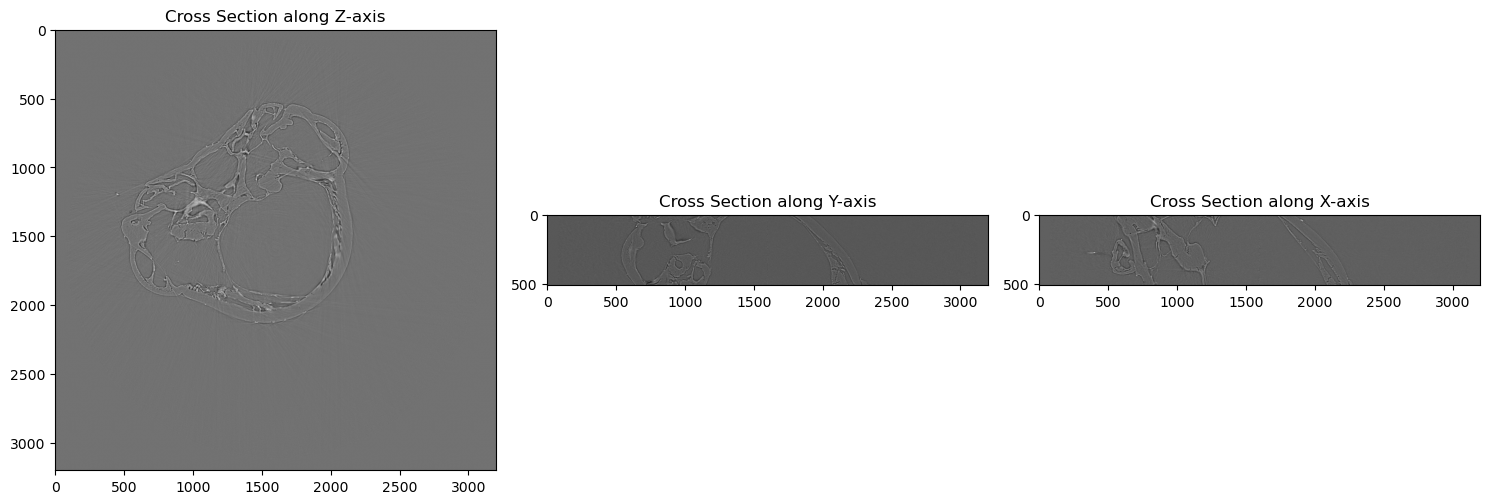

In [5]:
from tomo_flow.recon import show_images

show_images(proj_norm, recon)
plt.show()  